### Configurations And Data Collection

In [8]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast
from dataclasses import dataclass

@dataclass
class Meta: 
    alpha_name: str
    path: str

def collect_by_regex(source_folder: str, 
                     selector: re.Pattern):
    def collect(file: str):
        path = os.path.join(source_folder, file)
        return [
            Meta(
                alpha_name=selector.match(file).group(0),
                path=path),
            pd.read_csv(path)]

    plots =  [collect(file) 
              for file in os.listdir(source_folder) if selector.match(file)]
    
    # For printing aesthetic purposes, plots are sorted by their CSV names.
    plots.sort(key=lambda x: x[0].alpha_name)
    return plots

# This is taken from simulate.evaluate.calculate_angle.
def calculate_angle(p1,p2,p3):
    p1 = np.array(ast.literal_eval(p1))
    p2 = np.array(ast.literal_eval(p2))
    p3 = np.array(ast.literal_eval(p3))
    
    vec1 = p2 - p1
    vec2 = p3 - p1

    cos_theta = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical instability
    return np.degrees(angle)

def divide_closely_square(n):
    div_list = np.arange(1, n // 2 + 1)
    divisors = np.concatenate([div_list[n % div_list == 0], [n]])
    
    # Select middle and its pair to return
    middle = len(divisors) // 2
    return (divisors[middle], divisors[len(divisors) - 1 - middle])

def on_update(a: callable): pass

In [9]:
source_folder = ".."

for_angles = 0
for_dtw = 1
for_mse = 2

animal = pd.read_csv("../simulate/model/slow_with_linear_4.csv")
plots = [
    ("Angles", collect_by_regex(source_folder, 
    re.compile('.*(alpha-[+-]?([0-9]*[.])?[0-9]+)-type-Angles.csv$'))),
        
    ("DTW", collect_by_regex(source_folder, 
    re.compile('.*(alpha-[+-]?([0-9]*[.])?[0-9]+)-type-DTW.csv$'))),
    
    ("MSE", collect_by_regex(source_folder, 
    re.compile('.*(alpha-[+-]?([0-9]*[.])?[0-9]+)-type-MSE.csv$'))),
]


### Enable Live Updates Service For Data Collection

In [4]:
import time

subscriptions = []
check_delay = 0.5

def has_more_rows(path: str, loaded_length: int):
    with open(path) as f: return sum(1 for _ in f) - 1 > loaded_length

def update_service():
    def _process():
        while True:
            # Check every added CSV in the plot set if updates occured
            # We have to do these ugly loops like this because we need to 
            # preserve indices
            for plot_i, plot in enumerate(plots):
                name, dataset = plot
                for data_i, data in enumerate(dataset):
                    meta, df = data
                    if not has_more_rows(meta.path, len(df)): continue

                    mut_df = pd.read_csv(meta.path,
                                        skiprows=range(1, len(df) + 1))
                    
                    plots[plot_i][1][data_i][1] =\
                        pd.concat([df, mut_df], ignore_index=True)

                    [sub() for sub in subscriptions]

            time.sleep(check_delay)

    # service = threading.Thread(target=_process, daemon=True)
    # service.start()
    print("Service started")
    _process()

def on_update(a: callable):
    subscriptions.append(a)
    update_service()

### Generate Scores Over Time

/tmp/ipykernel_319374/2962432939.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()


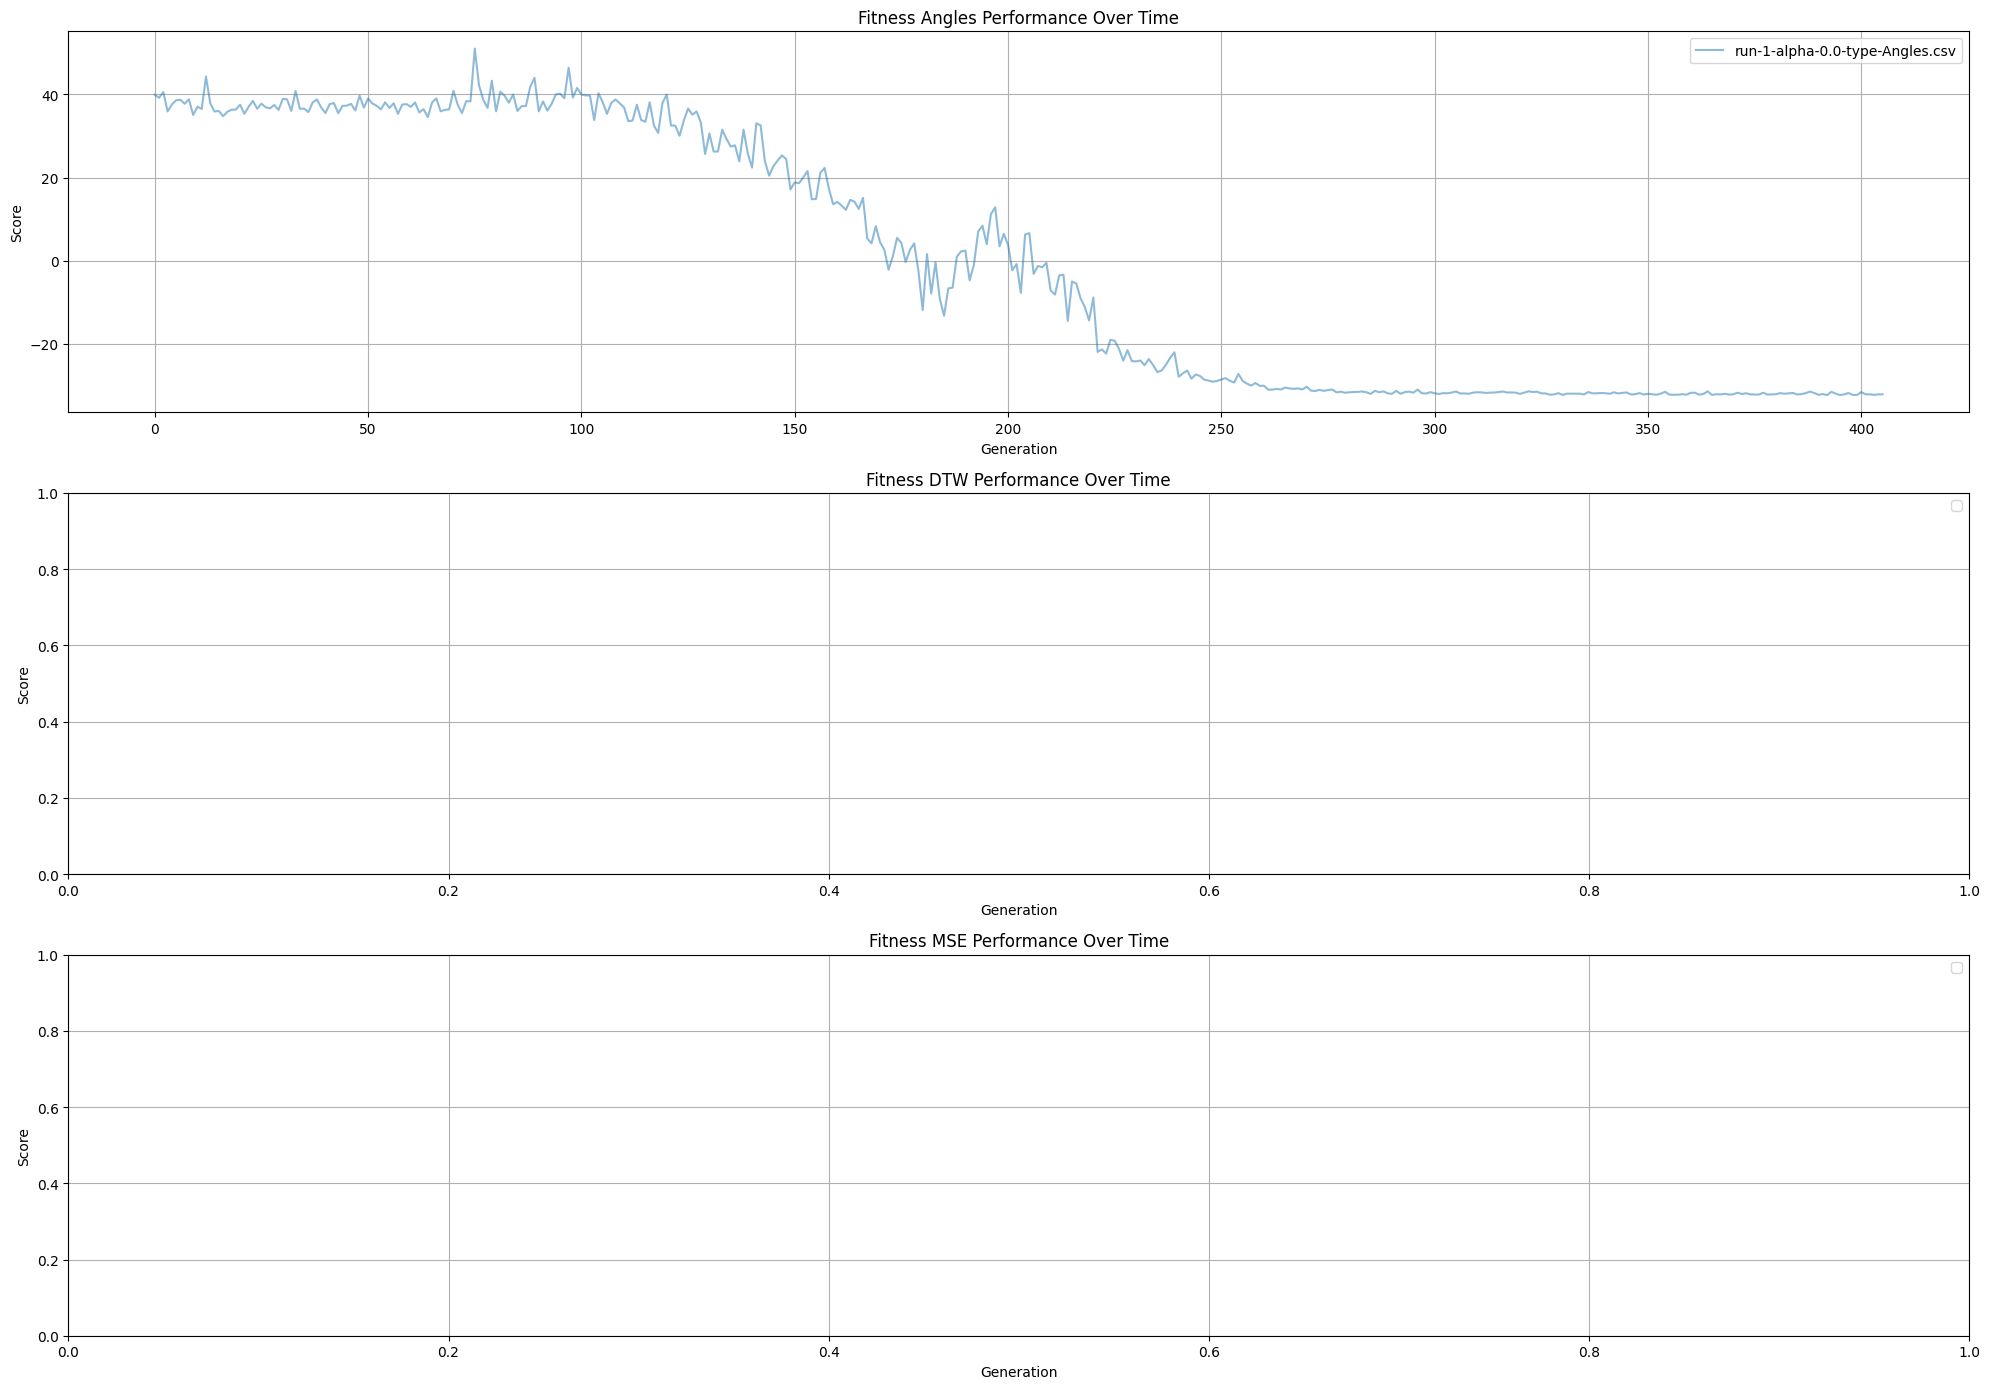

In [10]:

fig, ax = plt.subplots(len(plots),1,figsize=(20,14))

for i, plot in enumerate(plots):
    plot_name = plot[0]
    legend = []
    for meta, df in plot[1]:
        line, = ax[i].plot(
            df["generation"], 
            df["score"].ewm(alpha=1).mean().values,
            label=meta.alpha_name, alpha=0.5)
    ax[i].set_xlabel("Generation")
    ax[i].set_ylabel("Score")
    ax[i].set_title(f"Fitness {plot_name} Performance Over Time")

    ax[i].grid(visible=True, which="major")

    ax[i].legend()

fig.tight_layout()

### Generate Relative Angle Plots For Final Gen Over 5 Alphas

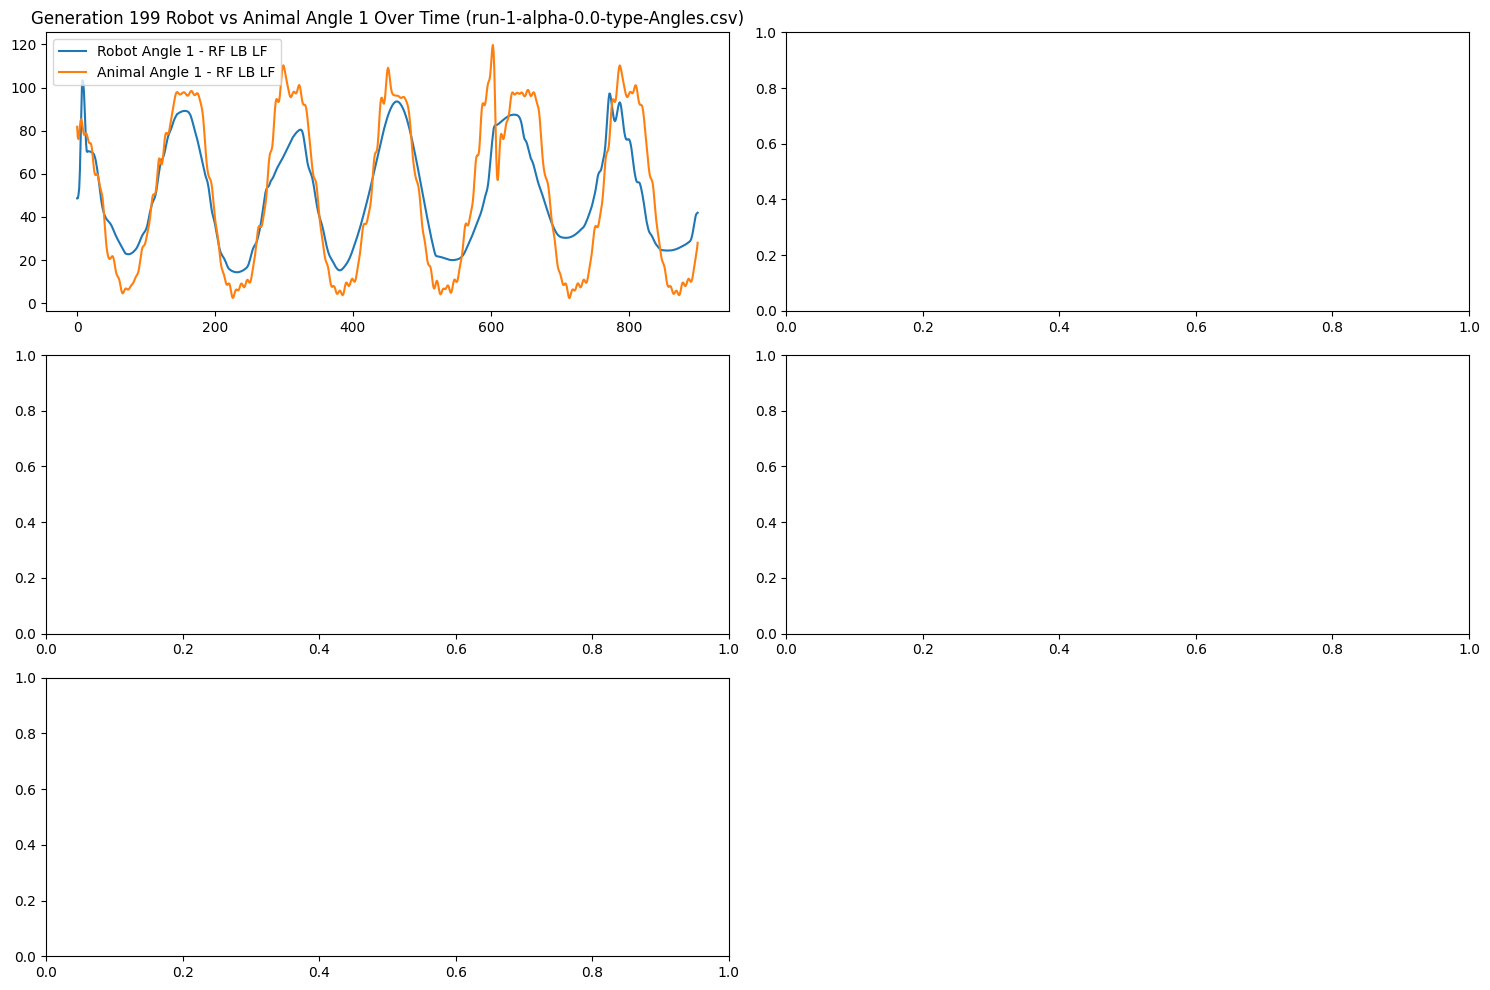

In [12]:
from IPython.display import clear_output

def gen():
    select_plot = for_angles

    name, dataset = plots[select_plot]

    # Before continuing, we need to generate the angle data for the animal dataset.
    # We do it here to save compute. Don't move it into the loop
    # Generate angle data for animal
    animal["angle1"] = animal.apply(lambda r:
                                    calculate_angle(
                                        r["right_front"],
                                        r["left_hind"],
                                        r["left_front"]
                                    ), axis=1)


    animal["angle2"] = animal.apply(lambda r:
                                    calculate_angle(
                                        r["left_front"],
                                        r["right_hind"],
                                        r["right_front"]
                                    ), axis=1)

    fix, ax = plt.subplots(3, 2, figsize=(15,10))

    ax = ax.ravel()
    ax[5].axis('off') # We only have 5 plots, so we dont need a 6th rendered
    ax_i = 0

    for meta, df in dataset:
        target_gen = df['generation'].max()
        # Only compute angles for the target generation requested
        df_target = df.query(f"generation == {target_gen - 1}")

        angle1 = df_target.apply(lambda r: calculate_angle(
            r["right_front"], r["left_hind"], r["left_front"]), axis=1)

        # Required for how matplotlib plots
        _animal = animal.iloc[:len(df_target)]
        t_axis = np.arange(len(df_target))

        ax[ax_i].set_title(f"Generation {target_gen} Robot vs Animal Angle 1 Over Time ({meta.alpha_name})")
        ax[ax_i].plot(t_axis, angle1, label="Robot Angle 1 - RF LB LF")
        ax[ax_i].plot(t_axis, _animal["angle1"], label="Animal Angle 1 - RF LB LF")
        ax[ax_i].legend()

        ax_i += 1

    plt.tight_layout()
    return plt

gen().show()

### Watch Angles Over Generations

405


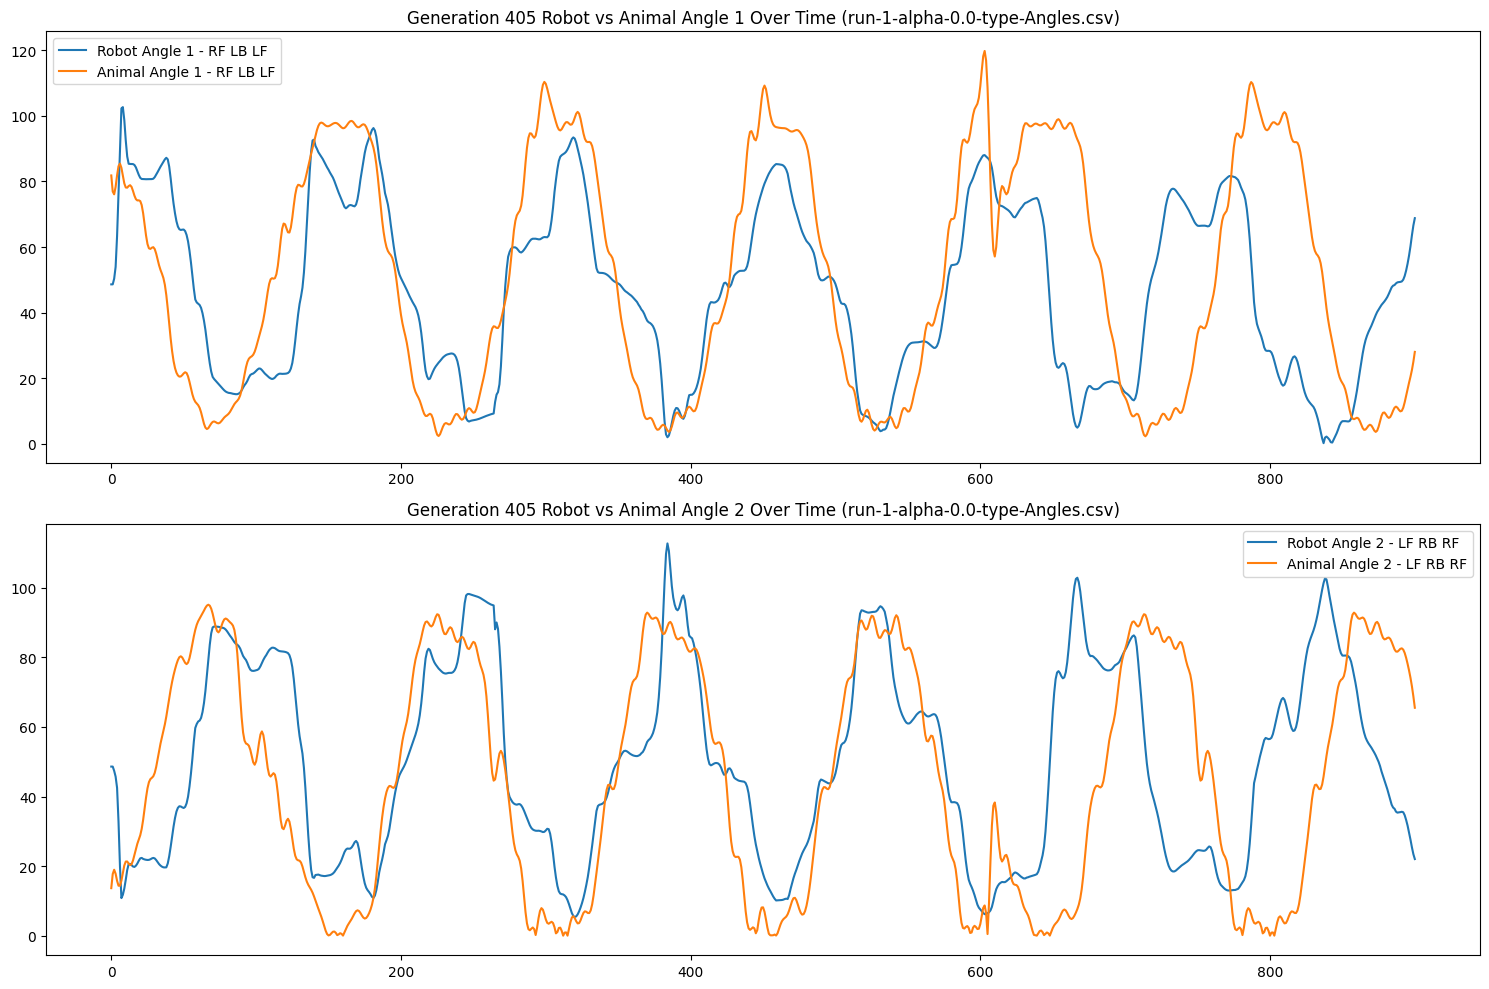

In [ ]:
from IPython.display import clear_output

# KEY:
# 0 -> 0
# 0.25 -> 1
# 0.5 -> 2
# 0.75 -> 3
# 1 -> 4

def gen():
    select_plot = for_angles

    name, dataset = plots[select_plot]

    # Before continuing, we need to generate the angle data for the animal dataset.
    # We do it here to save compute. Don't move it into the loop
    # Generate angle data for animal
    animal["angle1"] = animal.apply(lambda r:
                                    calculate_angle(
                                        r["right_front"],
                                        r["left_hind"],
                                        r["left_front"]
                                    ), axis=1)


    animal["angle2"] = animal.apply(lambda r:
                                    calculate_angle(
                                        r["left_front"],
                                        r["right_hind"],
                                        r["right_front"]
                                    ), axis=1)

    fix, ax = plt.subplots(2, 1,figsize=(15,10))
    ax = ax.ravel()
    meta, df = dataset[0]

    target_gen = df['generation'].max()
    # Only compute angles for the target generation requested
    df_target = df.query(f"generation == {100}")
    print(target_gen)

    angle1 = df_target.apply(lambda r: calculate_angle(
        r["right_front"], r["left_hind"], r["left_front"]), axis=1)


    angle2 = df_target.apply(lambda r: calculate_angle(
        r["left_front"], r["right_hind"], r["right_front"]), axis=1)
    
    # Required for how matplotlib plots
    _animal = animal.iloc[:len(df_target)]
    t_axis = np.arange(len(df_target))


    ax[0].set_title(f"Generation {target_gen} Robot vs Animal Angle 1 Over Time ({meta.alpha_name})")
    ax[0].plot(t_axis, angle1, label="Robot Angle 1 - RF LB LF")
    ax[0].plot(t_axis, _animal["angle1"], label="Animal Angle 1 - RF LB LF")
    ax[0].legend()

    ax[1].set_title(f"Generation {target_gen} Robot vs Animal Angle 2 Over Time ({meta.alpha_name})")
    ax[1].plot(t_axis, angle2, label="Robot Angle 2 - LF RB RF")
    ax[1].plot(t_axis, _animal["angle2"], label="Animal Angle 2 - LF RB RF")
    ax[1].legend()


    plt.tight_layout()
    return plt

def progressive_updates():
    plt = gen()
    clear_output(wait=True)
    plt.show()

gen().show()
on_update(progressive_updates)

### Generate Permutation Plots For All Possible Angles Sourced From Animal CSV

In [ ]:
from itertools import permutations
import math

columns_to_permute =strings = ["left_front", "right_front", "head", "middle", "rear", "left_hind", "right_hind"]

permute_angles = list(permutations(columns_to_permute, 3))

# Select only top 20% that deviate
max_i = round(len(permute_angles) * 0.2)
x_total, y_total = divide_closely_square(max_i)

print(f"Plotting graph with ({y_total},{x_total}) plots")

computed_angles = []

for a1,a2,a3 in permute_angles:
    dataset = animal.iloc[:900].apply(
        lambda r: calculate_angle(r[a1], r[a2], r[a3]), axis=1)

    # The standard deviation is proportional to the amplitude of the sin wave. 
    # We store this alongside the angles to filter what type of charts we want.
    # To display.
    std = np.std(dataset)
    computed_angles.append((std, f"{a1}<>{a2}<>{a3}", dataset))
    print(f"Computing: {a1}<>{a2}<>{a3} :-> {std}")

computed_angles.sort(key=lambda x: x[0], reverse=True)

fig, ax = plt.subplots(y_total, x_total, figsize=(40, 15))
ax = ax.ravel()

for i in range(max_i):
    std, name, angle_data = computed_angles[i]

    t_axis = np.arange(len(angle_data))

    ax[i].set_title(f"{name}\nSTD: {std}")
    ax[i].plot(t_axis, angle_data)
    ax[i].grid(visible=True)

fig.tight_layout()
fig.show()

### Generate Angle Accuracy Over Time

In [ ]:
import ast
import copy
import matplotlib.colors as mcolors

# Make a copy of the target generation
target_set = copy.deepcopy(dataset[for_angles][1].query(f"generation == {target_gen - 1}"))


# Generate angle data
target_set["angle1"]= target_set.apply(lambda r: 
                                       calculate_angle(
                                           r["right_front"], 
                                           r["left_hind"], 
                                           r["left_front"]
                                        ), axis=1)

target_set['angle2'] = target_set.apply(lambda r: 
                                        calculate_angle(
                                            r["left_front"], 
                                            r["right_hind"], 
                                            r["right_front"]
                                        ), axis=1)


# Generate angle data for animal
animal["angle1"] = animal.apply(lambda r:
                                calculate_angle(
                                    r["right_front"],
                                    r["left_hind"],
                                    r["left_front"]
                                ), axis=1)


animal["angle2"] = animal.apply(lambda r:
                                calculate_angle(
                                    r["left_front"],
                                    r["right_hind"],
                                    r["right_front"]
                                ), axis=1)


fig, ax = plt.subplots(figsize=(10,6))

t_axis = np.arange(len(target_set))
_animal = animal.iloc[:len(target_set)]

_animal = _animal.reset_index(drop=True)
target_set = target_set.reset_index(drop=True)
angle1_diff = abs(target_set["angle1"] - _animal["angle1"])
# angle2_diff = target_set["angle2"] - _animal["angle2"]

ax.set_title(f"Generation {target_gen} Robot vs Animal Angle 1 Over Time")
ax.plot(t_axis, angle1_diff, label="Angle 1 Difference")
# ax.plot(t_axis, angle2_diff, label="Angle 2 Difference")
ax.legend()


plt.show()